# Laboratorio 2 – Simulación de Montecarlo
Curso: Modelación y Simulación I – Maestría en Investigación de Operaciones  
Universidad Galileo – FISICC

## Ejercicio 1 – Ahorro Universitario con Rendimiento Variable

**Objetivo:**  
Determinar la probabilidad y comportamiento de un plan de ahorro a 17 años, con aportes anuales fijos y rendimiento variable anual.

**Datos:**
- Aporte anual: $20,000 (al inicio de cada año)
- Rendimiento: distribución normal (media = 4%, desviación estándar = 10%)
- Meta: $500,000 al final de 17 años
- Simulaciones: mínimo 1,000

**Resultados a reportar:**
- Rendimiento promedio total
- Monto promedio acumulado al final
- Escenario pesimista y optimista
- Gráficas:
  - Rendimientos por año
  - Monto ahorrado por año
  - Monto acumulado por año

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Parámetros (ajusta TRIALS si quieres igualar tus corridas previas)
# -------------------------------
ANIOS   = 17
APORTE  = 20_000.0
MEDIA   = 0.04
STD     = 0.10
TRIALS  = 100_000   # mínimo 1,000; súbelo si quieres más precisión
SEED    = 42
rng     = np.random.default_rng(SEED)

# -------------------------------
# Simulación
# -------------------------------
def simular_ruta(anios=ANIOS, aporte=APORTE, media=MEDIA, std=STD, rng=rng):
    """Aporte al inicio del año; luego se aplica el rendimiento del año."""
    r = rng.normal(media, std, anios)
    s = np.zeros(anios, dtype=float)
    saldo = 0.0
    for t in range(anios):
        saldo += aporte
        saldo *= (1.0 + r[t])
        s[t] = saldo
    return r, s

def simular_montecarlo(trials=TRIALS, anios=ANIOS, aporte=APORTE, media=MEDIA, std=STD, rng=rng):
    rend_all = np.zeros((trials, anios), dtype=float)
    saldo_all = np.zeros((trials, anios), dtype=float)
    for i in range(trials):
        r, s = simular_ruta(anios, aporte, media, std, rng)
        rend_all[i] = r
        saldo_all[i] = s
    return rend_all, saldo_all

rend_all, saldo_all = simular_montecarlo()

# -------------------------------
# Métricas solicitadas
# -------------------------------
monto_final = saldo_all[:, -1]

resumen = pd.DataFrame({
    "Métrica": [
        "Rendimiento anual promedio",
        "Monto final promedio",
        "Escenario pesimista (P5)",
        "Escenario optimista (P95)"
    ],
    "Valor": [
        f"{rend_all.mean():.2%}",
        f"${monto_final.mean():,.2f}",
        f"${np.percentile(monto_final, 5):,.2f}",
        f"${np.percentile(monto_final, 95):,.2f}",
    ]
})
resumen

,Métrica,Valor
0,Rendimiento anual promedio,4.01%
1,Monto final promedio,"$493,107.11"
2,Escenario pesimista (P5),"$313,398.86"
3,Escenario optimista (P95),"$729,167.42"


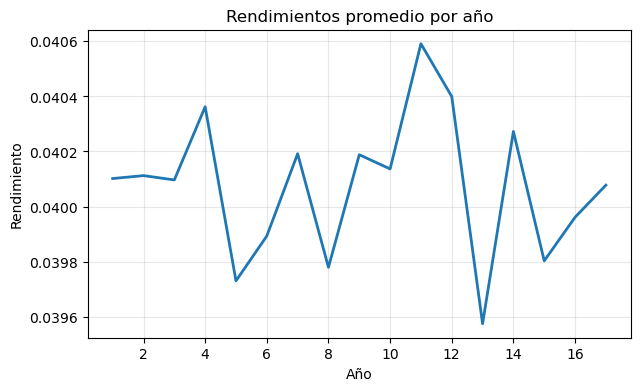

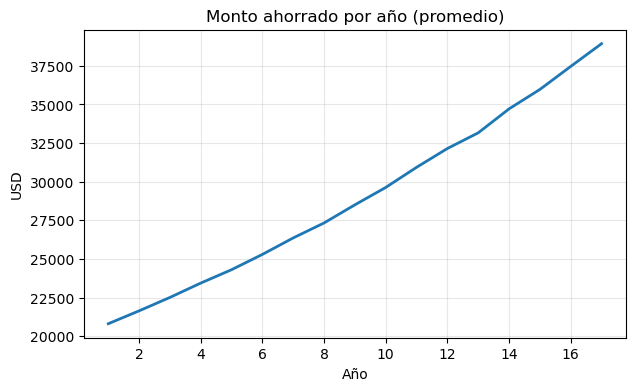

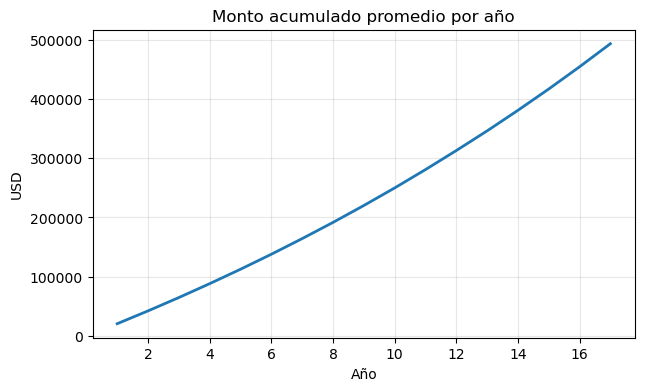

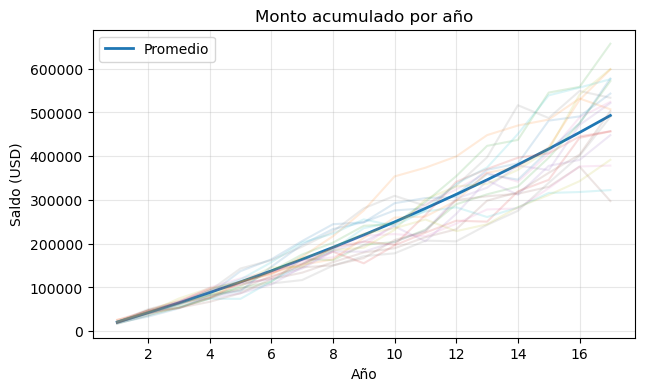

In [2]:
# -------------------------------
# Gráficas solicitadas
# -------------------------------
anios_axis = np.arange(1, ANIOS + 1)

# 1) Rendimientos obtenidos por año (promedio)
plt.figure(figsize=(7, 4))
plt.plot(anios_axis, rend_all.mean(axis=0), linewidth=2)
plt.title("Rendimientos promedio por año")
plt.xlabel("Año")
plt.ylabel("Rendimiento")
plt.grid(alpha=0.3)
plt.show()

# 2) Monto ahorrado por año (flujo promedio: saldo_t - saldo_{t-1})
flujo_all = np.empty_like(saldo_all)
flujo_all[:, 0] = saldo_all[:, 0]
if ANIOS > 1:
    flujo_all[:, 1:] = saldo_all[:, 1:] - saldo_all[:, :-1]
flujo_prom = flujo_all.mean(axis=0)

plt.figure(figsize=(7, 4))
plt.plot(anios_axis, flujo_prom, linewidth=2)
plt.title("Monto ahorrado por año (promedio)")
plt.xlabel("Año")
plt.ylabel("USD")
plt.grid(alpha=0.3)
plt.show()

# 3) Monto acumulado por año (promedio)
plt.figure(figsize=(7, 4))
plt.plot(anios_axis, saldo_all.mean(axis=0), linewidth=2)
plt.title("Monto acumulado promedio por año")
plt.xlabel("Año")
plt.ylabel("USD")
plt.grid(alpha=0.3)
plt.show()

# 3.1) Gráfica del monto acumulado (saldo) por año: promedio + algunas trayectorias ejemplo
plt.figure(figsize=(7, 4))
plt.plot(anios_axis, saldo_all.mean(axis=0), linewidth=2, label="Promedio")

# Muestra 20 trayectorias al azar para visualizar variabilidad
muestras = rng.choice(TRIALS, size=min(20, TRIALS), replace=False)
for idx in muestras:
    plt.plot(anios_axis, saldo_all[idx], alpha=0.15)
    
plt.title("Monto acumulado por año")
plt.xlabel("Año")
plt.ylabel("Saldo (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Ejercicio 2 – Optimización de Presupuesto Publicitario

**Objetivo:**  
Usar un modelo de regresión lineal para estimar ventas a partir de la inversión en TV, Radio y Periódico, y luego aplicar simulación de Montecarlo para encontrar combinaciones de inversión que maximicen las ventas.

**Datos:**
- Archivo: `Advertising.csv`
- Variables:
  - `Sales` (dependiente)
  - `TV`, `Radio`, `Newspaper` (independientes)
- Si no se puede ajustar una distribución estadística exacta (*bestfit*), se asume distribución **triangular**:
  - `min` = valor mínimo observado
  - `max` = valor máximo observado
  - `mode` = mediana observada

**Resultados a reportar:**
- Ecuación de regresión ajustada
- Valores de inversión óptimos para TV, Radio y Periódico que maximizan ventas
- Ventas estimadas para la combinación óptima
- Porcentaje de inversión de cada canal respecto al total

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from fitter import Fitter
import scipy.stats as st

# -------------------------------
# Cargar datos
# -------------------------------
df = pd.read_csv("Advertising.csv")  # asegúrate que esté junto al notebook
X = df[["TV", "Radio", "Newspaper"]].values
y = df["Sales"].values

# -------------------------------
# Ajustar modelo de regresión
# -------------------------------
modelo = LinearRegression()
modelo.fit(X, y)

coefs = dict(zip(["TV","Radio","Newspaper"], modelo.coef_))
intercepto = modelo.intercept_

print("Ecuación de regresión:")
print(f"Sales = {intercepto:.4f} + {coefs['TV']:.4f}*TV + {coefs['Radio']:.4f}*Radio + {coefs['Newspaper']:.4f}*Newspaper")

Ecuación de regresión:
Sales = 2.9389 + 0.0458*TV + 0.1885*Radio + -0.0010*Newspaper


2025-08-10 22:00:13.395 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000208)
2025-08-10 22:00:13.441 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000208)
2025-08-10 22:00:13.451 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted weibull_min distribution with error=0.000205)
2025-08-10 22:00:13.454 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.00014)
2025-08-10 22:00:13.461 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000266)
2025-08-10 22:00:13.477 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.000209)
2025-08-10 22:00:13.527 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.008111)
2025-08-10 22:00:13.529 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted w

,Variable,Distribución,Parámetros
0,TV,beta,"{'shapes': (), 'loc': 0.6999999999999998, 'sca..."
1,Radio,beta,"{'shapes': (), 'loc': -8.97387392122328e-11, '..."
2,Newspaper,beta,"{'shapes': (), 'loc': 0.18804589330583937, 'sc..."


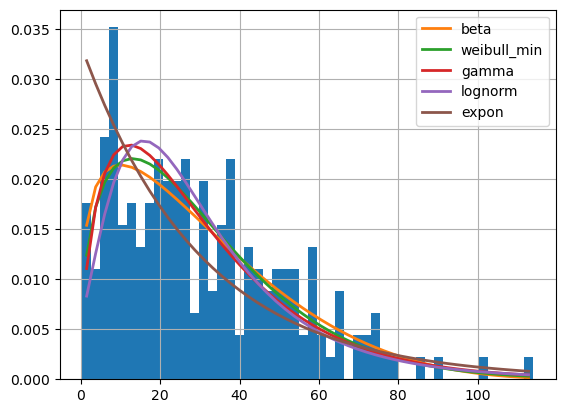

In [4]:
# Distribuciones candidatas (como en clase)
CANDIDATAS = [
    'norm', 'lognorm', 'beta', 'expon', 'gamma', 'weibull_min'
]

def bestfit_una_variable(x: pd.Series, candidatas=CANDIDATAS, bins=50):
    """
    Ajusta varias distribuciones y retorna (nombre, params_dict, resumen_fitter).
    params_dict: {'shapes': tuple|None, 'loc': float, 'scale': float}
    """
    datos = x.dropna().values
    f = Fitter(datos, distributions=candidatas, bins=bins)
    f.fit()
    f.summary()  # muestra resumen de ajustes
    try:
        best = f.get_best(method='ks')  # o 'ks_statistic' según versión
    except Exception:
        best = f.get_best()  # fallback
    if not best:
        raise ValueError("No se encontraron distribuciones adecuadas para ajustar.")

    dist_name = list(best.keys())[0]
    raw = best[dist_name]
    # Fitter a veces devuelve 'args' (shapes). Normalizamos a dict simple.
    shapes = tuple(raw['args']) if 'args' in raw else ()
    params = {'shapes': shapes, 'loc': float(raw['loc']), 'scale': float(raw['scale'])}
    return dist_name, params, f

def triangular_params_desde_datos(x: pd.Series):
    a = float(x.min())
    b = float(x.max())
    m = float(x.median())  # moda aproximada
    # Garantizar a <= m <= b
    m = max(min(m, b), a)
    return a, m, b

# Ajuste por variable
best_TV_name, best_TV_params, f_TV = bestfit_una_variable(df["TV"])
best_RA_name, best_RA_params, f_RA = bestfit_una_variable(df["Radio"])
best_NE_name, best_NE_params, f_NE = bestfit_una_variable(df["Newspaper"])

tabla_best = pd.DataFrame([
    {"Variable":"TV", "Distribución":best_TV_name, "Parámetros":best_TV_params},
    {"Variable":"Radio", "Distribución":best_RA_name, "Parámetros":best_RA_params},
    {"Variable":"Newspaper", "Distribución":best_NE_name, "Parámetros":best_NE_params},
])
tabla_best

In [5]:
def sample_from_fit(dist_name: str, params: dict, size: int, rng: np.random.Generator):
    """
    Genera muestras usando scipy.stats.<dist>.rvs con parámetros (shapes, loc, scale).
    """
    shapes = params.get('shapes', ())
    loc = params.get('loc', 0.0)
    scale = params.get('scale', 1.0)

    # Mapa básico a scipy
    dist_map = {
        'norm': st.norm,
        'lognorm': st.lognorm,       # shape = s
        'beta': st.beta,             # shapes = (a, b)
        'expon': st.expon,
        'gamma': st.gamma,           # shape = a
        'weibull_min': st.weibull_min,
    }
    if dist_name not in dist_map:
        raise ValueError(f"Distribución no soportada: {dist_name}")

    dist = dist_map[dist_name]
    # rvs(*shapes, loc=..., scale=..., size=...)
    return dist.rvs(*shapes, loc=loc, scale=scale, size=size, random_state=rng)

def muestrear_variable(x: pd.Series, best_name: str, best_params: dict,
                       size: int, rng: np.random.Generator):
    """Intenta muestrear de la mejor distribución; si falla, usa Triangular(min, moda, max)."""
    try:
        muestras = sample_from_fit(best_name, best_params, size, rng)
        return muestras, best_name, best_params, "bestfit"
    except Exception:
        a, m, b = triangular_params_desde_datos(x)
        muestras = rng.triangular(a, m, b, size)
        return muestras, "triangular", {"a":a, "m":m, "b":b}, "triangular"

In [6]:
TRIALS = 1000
SEED = 123
rng = np.random.default_rng(SEED)

# Muestreo para cada canal
tv_sim, use_tv_name, use_tv_params, src_tv = muestrear_variable(df["TV"], best_TV_name, best_TV_params, TRIALS, rng)
ra_sim, use_ra_name, use_ra_params, src_ra = muestrear_variable(df["Radio"], best_RA_name, best_RA_params, TRIALS, rng)
ne_sim, use_ne_name, use_ne_params, src_ne = muestrear_variable(df["Newspaper"], best_NE_name, best_NE_params, TRIALS, rng)

# Predicción de ventas
Xsim = np.column_stack([tv_sim, ra_sim, ne_sim])
ventas_pred = modelo.predict(Xsim)

# Mejor combinación
idx = int(np.argmax(ventas_pred))
tv_opt, ra_opt, ne_opt = float(tv_sim[idx]), float(ra_sim[idx]), float(ne_sim[idx])
ventas_opt = float(ventas_pred[idx])

total_opt = tv_opt + ra_opt + ne_opt
pct_tv = tv_opt / total_opt if total_opt > 0 else 0.0
pct_ra = ra_opt / total_opt if total_opt > 0 else 0.0
pct_ne = ne_opt / total_opt if total_opt > 0 else 0.0

print("Distribuciones usadas para muestreo:")
print(f"  TV        -> {use_tv_name} ({src_tv})")
print(f"  Radio     -> {use_ra_name} ({src_ra})")
print(f"  Newspaper -> {use_ne_name} ({src_ne})")

resumen_optimo = pd.DataFrame({
    "Canal": ["TV","Radio","Newspaper"],
    "Inversión óptima": [tv_opt, ra_opt, ne_opt],
    "Porcentaje": [pct_tv, pct_ra, pct_ne]
})
print(f"\nVentas estimadas óptimas: {ventas_opt:.3f}")
resumen_optimo

Distribuciones usadas para muestreo:
  TV        -> triangular (triangular)
  Radio     -> triangular (triangular)
  Newspaper -> triangular (triangular)

Ventas estimadas óptimas: 24.204


,Canal,Inversión óptima,Porcentaje
0,TV,292.280317,0.726974
1,Radio,42.214574,0.104998
2,Newspaper,67.555908,0.168028


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


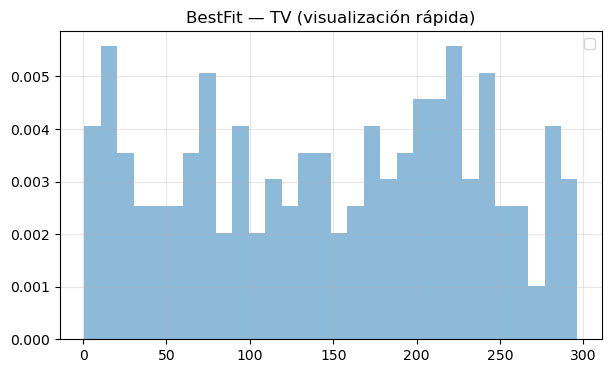

Resultados guardados en 'resultados_optimizacion.csv'


,Métrica,Valor,Canal,Inversión óptima,Porcentaje
0,Rendimiento anual promedio,4.01%,NaN,NaN,NaN
1,Monto final promedio,"$493,107.11",NaN,NaN,NaN
2,Escenario pesimista (P5),"$313,398.86",NaN,NaN,NaN
3,Escenario optimista (P95),"$729,167.42",NaN,NaN,NaN
4,NaN,NaN,TV,292.280317,0.726974
5,NaN,NaN,Radio,42.214574,0.104998
6,NaN,NaN,Newspaper,67.555908,0.168028
7,Inversión óptima TV,$292.28,NaN,NaN,NaN
8,Inversión óptima Radio,$42.21,NaN,NaN,NaN
9,Inversión óptima Newspaper,$67.56,NaN,NaN,NaN


In [7]:
# Histograma + PDF ajustado para una variable (ejemplo: TV)
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(df["TV"], bins=30, density=True, alpha=0.5)

try:
    xs = np.linspace(df["TV"].min(), df["TV"].max(), 200)
    ys = sample_from_fit(use_tv_name, use_tv_params, size=10_000, rng=np.random.default_rng(999))
    ax.plot(sorted(xs), np.histogram(ys, bins=50, density=True)[0], label=f"PDF aproximada: {use_tv_name}")
except Exception:
    pass

ax.set_title("BestFit — TV (visualización rápida)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()
# Resumen de resultados
resumen_final = pd.DataFrame({
    "Métrica": [
        "Inversión óptima TV",
        "Inversión óptima Radio",
        "Inversión óptima Newspaper",
        "Porcentaje TV",
        "Porcentaje Radio",
        "Porcentaje Newspaper",
        "Ventas estimadas óptimas"
    ],
    "Valor": [
        f"${tv_opt:.2f}",
        f"${ra_opt:.2f}",
        f"${ne_opt:.2f}",
        f"{pct_tv:.2%}",
        f"{pct_ra:.2%}",
        f"{pct_ne:.2%}",
        f"{ventas_opt:.3f}"
    ]
})
resumen_final = pd.concat([resumen, resumen_optimo, resumen_final], ignore_index=True)
# Guardar resultados en CSV
resumen_final.to_csv("resultados_optimizacion.csv", index=False)
print("Resultados guardados en 'resultados_optimizacion.csv'")
# Resumen de resultados
resumen_final